In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

In [2]:
# Data Preprocessing
target_shape = (256, 256)

target_height, target_width = target_shape

def resize_with_aspect_ratio(img, target_height):
    original_width, original_height = img.size
    aspect_ratio = original_width / original_height
    target_width = int(target_height * aspect_ratio)
    return img.resize((target_width, target_height))

transform_color = transforms.Compose([
    transforms.Lambda(lambda x: resize_with_aspect_ratio(x, target_height)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

transform_gray = transforms.Compose([
    transforms.Lambda(lambda x: resize_with_aspect_ratio(x, target_height)),
    transforms.Grayscale(num_output_channels=1),
    transforms.Lambda(lambda x: torch.cat([x, x, x], 0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [3]:
def load_and_transform_images(folder, transform):
    images = []
    for filename in os.listdir(folder):
        try:
            path = os.path.join(folder, filename)
            img = Image.open(path).convert("RGB")  # Convert to RGB
            img = transform(img)  # Ensure this includes a ToTensor() step
            images.append(img)
            print(f"Transformed image shape: {img.shape}")
        except Exception as e:
            print(f"Error processing {filename}: {e}")
    return torch.stack(images)

In [4]:
# Paths to your image folders
color_folder = "/Users/varshit_madi/Downloads/ColTran/dataset/color_img"
gray_folder = "/Users/varshit_madi/Downloads/ColTran/dataset/grey_img"

In [5]:
# Load and transform images
color_images = load_and_transform_images(color_folder, transform_color)
grey_images = load_and_transform_images(gray_folder, transform_color)

Transformed image shape: torch.Size([3, 256, 455])
Transformed image shape: torch.Size([3, 256, 455])
Transformed image shape: torch.Size([3, 256, 455])
Transformed image shape: torch.Size([3, 256, 455])
Transformed image shape: torch.Size([3, 256, 455])
Transformed image shape: torch.Size([3, 256, 455])
Transformed image shape: torch.Size([3, 256, 455])
Transformed image shape: torch.Size([3, 256, 455])
Transformed image shape: torch.Size([3, 256, 455])
Transformed image shape: torch.Size([3, 256, 455])
Transformed image shape: torch.Size([3, 256, 455])
Transformed image shape: torch.Size([3, 256, 455])
Transformed image shape: torch.Size([3, 256, 455])
Transformed image shape: torch.Size([3, 256, 455])
Transformed image shape: torch.Size([3, 256, 455])
Transformed image shape: torch.Size([3, 256, 455])
Transformed image shape: torch.Size([3, 256, 455])
Transformed image shape: torch.Size([3, 256, 455])
Transformed image shape: torch.Size([3, 256, 455])
Transformed image shape: torch.

In [6]:
print("Grey Tensor Shape:", grey_images.shape)
print("Color Tensor Shape:", color_images.shape)

Grey Tensor Shape: torch.Size([88, 3, 256, 455])
Color Tensor Shape: torch.Size([88, 3, 256, 455])


In [7]:
def show_first_three_images(tensor, title="Images"):
    fig, axes = plt.subplots(1, 3, figsize=(15, 3))
    fig.suptitle(title)

    for i in range(3):
        img = tensor[i].permute(1, 2, 0).numpy()
        img = img * 0.5 + 0.5  # Undo normalization
        img = np.clip(img, 0, 1)

        axes[i].imshow(img)
        axes[i].axis('off')

    plt.show()


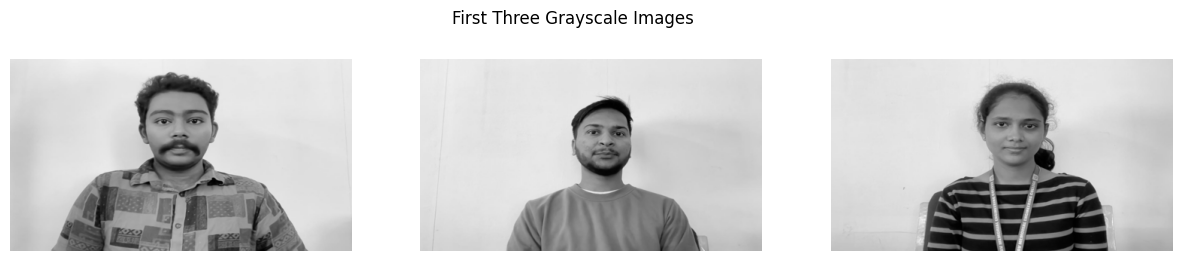

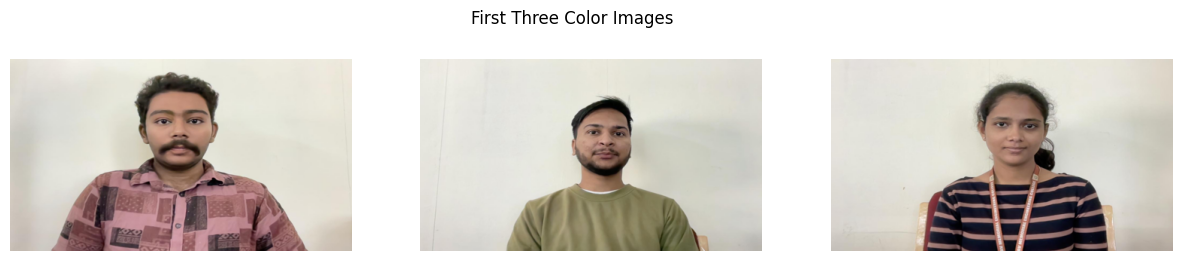

In [8]:
# Display first three grayscale images
show_first_three_images(grey_images, title="First Three Grayscale Images")

# Display first three color images
show_first_three_images(color_images, title="First Three Color Images")

In [9]:
# Dataset and DataLoader
class CustomDataset(Dataset):
    def __init__(self, grey_data, color_data):
        self.grey_data = grey_data
        self.color_data = color_data

    def __len__(self):
        return len(self.grey_data)

    def __getitem__(self, idx):
        return self.grey_data[idx], self.color_data[idx]

In [10]:
dataset = CustomDataset(grey_images, color_images)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

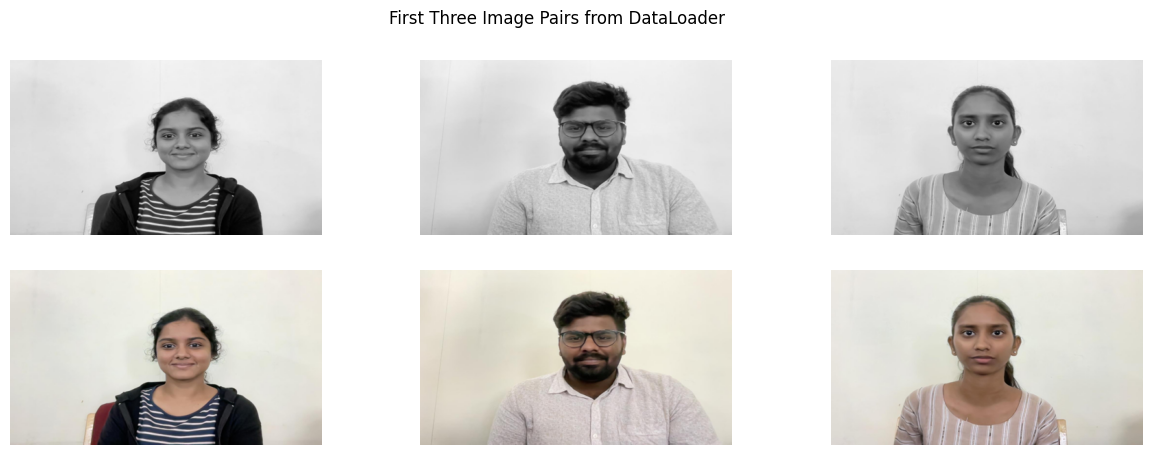

In [11]:
def show_first_three_pairs_from_dataloader(dataloader):
    fig, axes = plt.subplots(2, 3, figsize=(15, 5))  # 2 rows for grayscale and color images
    fig.suptitle("First Three Image Pairs from DataLoader")

    for batch_index, (grey_batch, color_batch) in enumerate(dataloader):
        for i in range(3):
            grey_img = grey_batch[i].permute(1, 2, 0).numpy()
            grey_img = grey_img * 0.5 + 0.5
            grey_img = np.clip(grey_img, 0, 1)
            color_img = color_batch[i].permute(1, 2, 0).numpy()
            color_img = color_img * 0.5 + 0.5
            color_img = np.clip(color_img, 0, 1)

            axes[0, i].imshow(grey_img)
            axes[0, i].axis('off')
            axes[1, i].imshow(color_img)
            axes[1, i].axis('off')

        break  # Only show the first batch

    plt.show()

# Display first three image pairs from dataloader
show_first_three_pairs_from_dataloader(dataloader)


In [12]:
import torch.nn as nn

class CNNFeatureExtractor(nn.Module):
    def __init__(self):
        super(CNNFeatureExtractor, self).__init__()
        # Layer 1: Input 256x256x3, Output 128x128x64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.norm1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2)

        # Layer 2: Input 128x128x64, Output 64x64x128
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.norm2 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2)

        # Layer 3: Input 64x64x128, Output 32x32x256
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.norm3 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(2)

    def forward(self, x):
        x = self.pool1(self.relu1(self.norm1(self.conv1(x))))
        x = self.pool2(self.relu2(self.norm2(self.conv2(x))))
        x = self.pool3(self.relu3(self.norm3(self.conv3(x))))
        return x


In [13]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(MultiHeadAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads

        assert (
            self.head_dim * heads == embed_size
        ), "Embed size needs to be divisible by heads"

        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.fc_out = nn.Linear(heads * self.head_dim, embed_size)

    def forward(self, values, keys, query, mask):
        N = query.shape[0]
        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]

        # Split the embedding into self.heads different pieces
        values = values.reshape(N, value_len, self.heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        queries = query.reshape(N, query_len, self.heads, self.head_dim)

        values = self.values(values)
        keys = self.keys(keys)
        queries = self.queries(queries)

        # Einsum does matrix multiplication for query*keys for each training example
        # with every other training example, don't be confused by einsum
        # it's just a way to do batch matrix multiplication
        attention = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])

        if mask is not None:
            attention = attention.masked_fill(mask == 0, float("-1e20"))

        attention = torch.softmax(attention / (self.embed_size ** (1 / 2)), dim=3)

        out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(
            N, query_len, self.heads * self.head_dim
        )

        out = self.fc_out(out)
        return out

In [14]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_size, heads, dropout, forward_expansion):
        super(TransformerBlock, self).__init__()
        self.attention = MultiHeadAttention(embed_size, heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)

        self.feed_forward = nn.Sequential(
            nn.Linear(embed_size, forward_expansion * embed_size),
            nn.ReLU(),
            nn.Linear(forward_expansion * embed_size, embed_size),
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, value, key, query, mask):
        attention = self.attention(value, key, query, mask)

        # Add skip connection, run through normalization and finally dropout
        x = self.dropout(self.norm1(attention + query))
        forward = self.feed_forward(x)
        out = self.dropout(self.norm2(forward + x))
        return out

In [15]:
class Transformer(nn.Module):
    def __init__(self, embed_size, num_layers, heads, forward_expansion, dropout, device):
        super(Transformer, self).__init__()
        self.embed_size = embed_size
        self.device = device
        self.layers = nn.ModuleList(
            [
                TransformerBlock(
                    embed_size,
                    heads,
                    dropout=dropout,
                    forward_expansion=forward_expansion
                )
                for _ in range(num_layers)
            ]
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        out = self.dropout(x)
        for layer in self.layers:
            out = layer(out, out, out, mask)

        return out

In [16]:
class ColorizationModel(nn.Module):
    def __init__(self, embed_size, num_layers, heads, forward_expansion, dropout, device):
        super(ColorizationModel, self).__init__()
        self.feature_extractor = CNNFeatureExtractor()
        self.transformer = Transformer(
            embed_size,
            num_layers,
            heads,
            forward_expansion,
            dropout,
            device
        )

        # Correct the upsampling and refinement layers
        self.upconv1 = nn.ConvTranspose2d(embed_size, embed_size // 2, kernel_size=2, stride=2)
        self.upconv2 = nn.ConvTranspose2d(embed_size // 2, embed_size // 4, kernel_size=2, stride=2)
        self.upconv3 = nn.ConvTranspose2d(embed_size // 4, embed_size // 8, kernel_size=2, stride=2)
        self.final_conv = nn.Conv2d(embed_size // 8, 3, kernel_size=3, padding=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, mask=None):
        features = self.feature_extractor(x)
        b, c, h, w = features.size()
        features = features.view(b, c, -1).permute(2, 0, 1)
        transformer_output = self.transformer(features, mask)
        transformer_output = transformer_output.permute(1, 2, 0).view(b, c, h, w)

        # Upsample and refine the output
        x = F.relu(self.upconv1(transformer_output))
        x = F.relu(self.upconv2(x))
        x = F.relu(self.upconv3(x))
        x = self.sigmoid(self.final_conv(x))
        return x


In [17]:
device = torch.device("cpu")
model = ColorizationModel(
    embed_size=256, 
    num_layers=6, 
    heads=8, 
    forward_expansion=4, 
    dropout=0, 
    device=device
).to(device)

In [18]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [19]:
# Training Loop
def train(model, dataloader, optimizer, loss_fn, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for grey_images, color_images in dataloader:
            grey_images = grey_images.to(device)
            color_images = color_images.to(device)

            # Forward pass
            predictions = model(grey_images)
            loss = loss_fn(predictions, color_images)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(dataloader)}')
        
    # saving model
    torch.save(model, 'colorization_savedModel.pth')

In [20]:
# Train the Model
num_epochs = 110
train(model, dataloader, optimizer, loss_fn, num_epochs)

/Users/varshit_madi/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 3, 256, 455])) that is different to the input size (torch.Size([32, 3, 256, 448])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (448) must match the size of tensor b (455) at non-singleton dimension 3

In [26]:
# Load the model
loaded_model = torch.load('colorization_savedModel.pth', map_location=device)
loaded_model = loaded_model.to(device)
loaded_model.eval()

ColorizationModel(
  (feature_extractor): CNNFeatureExtractor(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU()
    (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU()
    (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu3): ReLU()
    (norm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (transformer): Transformer(
    (layers): ModuleList(
      (0-3): 4 x TransformerBlock

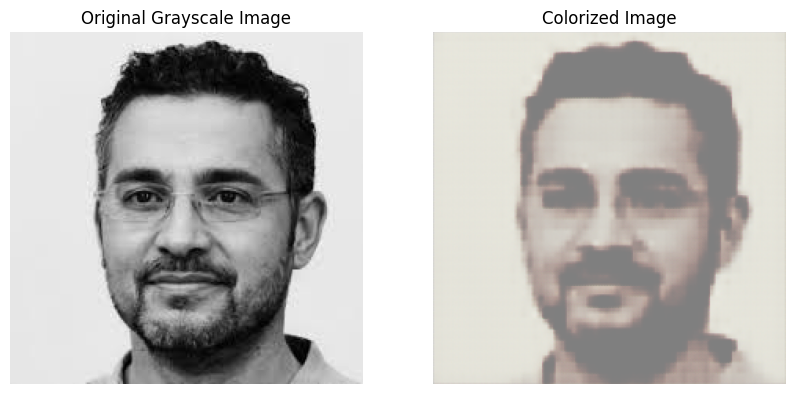

In [33]:
# Define the transformation for the grayscale image
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Assuming this was the training input size
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

image_path = 'C:/Users/rohit/Desktop/Model Test/test2.jpeg'
grey_image = Image.open(image_path).convert('L')  # Convert to grayscale
transformed_grey_image = transform(grey_image).unsqueeze(0)  # Add batch dimension

# Expand the grayscale image to have 3 channels to match the model's input expectations
transformed_grey_image = transformed_grey_image.expand(-1, 3, -1, -1)

# Ensure both the model and image are on the CPU
transformed_grey_image = transformed_grey_image.to('cpu')
model = model.to('cpu')

# Colorize the image
with torch.no_grad():
    colorized_output = model(transformed_grey_image)

# Convert the output tensor to a PIL image
colorized_output = colorized_output.squeeze(0).permute(1, 2, 0)  # Remove batch dim and rearrange color channels
colorized_output = colorized_output * 0.5 + 0.5  # Denormalize
colorized_output = colorized_output.clamp(0, 1)
colorized_output = (colorized_output.numpy() * 255).astype('uint8')
colorized_image = Image.fromarray(colorized_output)

# Display the grayscale and colorized images
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(grey_image, cmap='gray')
axes[0].set_title('Original Grayscale Image')
axes[0].axis('off')

axes[1].imshow(colorized_image)
axes[1].set_title('Colorized Image')
axes[1].axis('off')

plt.show()

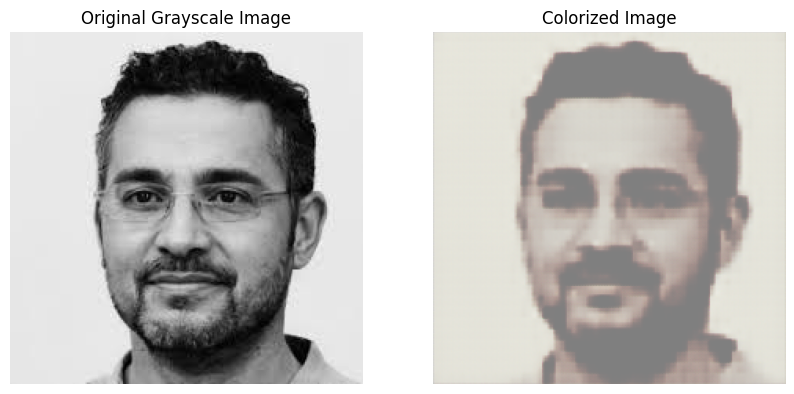

In [31]:

# Assuming 'target_shape' is a tuple (height, width)
target_height, target_width = target_shape

def resize_with_aspect_ratio(img, target_height):
    original_width, original_height = img.size
    aspect_ratio = original_width / original_height
    target_width = int(target_height * aspect_ratio)
    return img.resize((target_width, target_height))

# Define the transformation for the grayscale image
transform = transforms.Compose([
    transforms.Lambda(lambda x: resize_with_aspect_ratio(x, target_height)),
    transforms.Lambda(lambda x: x.convert('RGB') if x.mode != 'RGB' else x),  # Convert to RGB if not already
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # Repeat the single channel to simulate RGB
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

image_path = 'C:/Users/rohit/Desktop/Model Test/test2.jpeg'
grey_image = Image.open(image_path).convert('L')  # Convert to grayscale
transformed_grey_image = transform(grey_image).unsqueeze(0)  # Add batch dimension

# Expand the grayscale image to have 3 channels to match the model's input expectations
transformed_grey_image = transformed_grey_image.expand(-1, 3, -1, -1)

# Ensure both the model and image are on the CPU
transformed_grey_image = transformed_grey_image.to('cpu')
model = model.to('cpu')

# Colorize the image
with torch.no_grad():
    colorized_output = model(transformed_grey_image)

# Convert the output tensor to a PIL image
colorized_output = colorized_output.squeeze(0).permute(1, 2, 0)  # Remove batch dim and rearrange color channels
colorized_output = colorized_output * 0.5 + 0.5  # Denormalize
colorized_output = colorized_output.clamp(0, 1)
colorized_output = (colorized_output.numpy() * 255).astype('uint8')
colorized_image = Image.fromarray(colorized_output)

# Display the grayscale and colorized images
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(grey_image, cmap='gray')
axes[0].set_title('Original Grayscale Image')
axes[0].axis('off')

axes[1].imshow(colorized_image)
axes[1].set_title('Colorized Image')
axes[1].axis('off')

plt.show()
